In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# cur_dir = "/content/drive/Othercomputers/My laptop/POLIMI/AN2DL/AN2DL_CH_2/Notebooks"
# %cd $cur_dir

In [5]:
%pip install torchview

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\lgnbl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 1. Import Libraries

In [6]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

'pkill' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


PyTorch version: 2.5.1+cu121
Device: cuda


## **2. Data Loading**

In [7]:
USE_UNMASKED = False  # @param {type:"boolean"}

In [8]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")

test_data_path = os.path.join(datasets_path, "test_data")

output_path = os.path.join(datasets_path, "train_masked")

if USE_UNMASKED:
    resized_path = os.path.join(datasets_path, "train_resized")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")
if USE_UNMASKED:
    print(f"Resized path: {resized_path}")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path             # Folder containing img_xxxx and mask_xxxx
OUTPUT_FOLDER = output_path
if USE_UNMASKED:                   # Where the resized and masked images will be saved
    RESIZED_FOLDER = resized_path               # Where the resized unmasked images will be saved

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ..\an2dl2526c2
Train data path: ..\an2dl2526c2\train_data
Train labels path: ..\an2dl2526c2\train_labels.csv
Test data path: ..\an2dl2526c2\test_data
Output path: ..\an2dl2526c2\train_masked


In [9]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224)):
    """
    Loads an image and a mask, resizes them, applies the mask, and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        # Resize image using linear interpolation (better for photos)
        img = cv2.resize(img, target_size)
        # Resize mask using nearest neighbor to preserve sharp edges
        mask = cv2.resize(mask, target_size)

    # 4. Ensure mask is strictly binary (0 or 255)
    # Values > 127 become 255 (White), others become 0 (Black)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Apply the mask
    # cv2.bitwise_and keeps the pixel where the mask is 255, and makes it 0 where mask is 0
    masked_img = cv2.bitwise_and(img, img, mask=binary_mask)

    # 6. Save result
    cv2.imwrite(str(output_path), masked_img)

In [10]:
def process_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx',
    resizes them to target_size, and saves the masked result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)

    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir()
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]

    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0

    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct expected mask filename: img_123.jpg -> mask_123.jpg
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name

        # Fallback: If mask_123.jpg doesn't exist, try mask_123.png
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")

        if mask_path.exists():
            output_path = output_dir / file_path.name

            if output_path.exists():
                # Skip silently
                continue

            apply_mask(file_path, mask_path, output_path, target_size=target_size)
            count += 1
        else:
            # Use tqdm.write to log errors without breaking the progress bar
            tqdm.write(f"Skipping {file_path.name}: No matching mask found (looked for {mask_name})")

    print(f"Batch processing complete. Processed {count} new images.")

def resize_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds 'img_xxxx', resizes them to target_size,
    and saves the result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)

    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir()
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]

    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0

    for file_path in tqdm(image_files, desc="Resizing Images", unit="img"):
        output_path = output_dir / file_path.name

        if output_path.exists():
            # Skip silently
            continue

        img = cv2.imread(str(file_path))
        if img is None:
            continue

        if target_size is not None:
            img = cv2.resize(img, target_size)

        cv2.imwrite(str(output_path), img)
        count += 1

    print(f"Resizing complete. Processed {count} new images.")

In [11]:
def load_images_from_folder(folder, resize=None, filter_prefix=None):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images
        resize (tuple): Target size (width, height) or None
        filter_prefix (str): Prefix to filter filenames (e.g. 'img_')

    Returns:
        tuple: (np.ndarray of images, list of filenames)
    """
    images = []
    loaded_filenames = []

    # Get the list of files to iterate over
    file_list = sorted(os.listdir(folder))

    # Filter files before iterating to show correct progress
    if filter_prefix:
        file_list = [f for f in file_list if f.startswith(filter_prefix)]

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            # print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        if resize:
            img = cv2.resize(img, resize)

        images.append(img)
        loaded_filenames.append(filename)

    return np.array(images), loaded_filenames

In [12]:
process_batch(SOURCE_FOLDER, OUTPUT_FOLDER, target_size=TARGET_SIZE)
MASKED_IMAGE_PATH = OUTPUT_FOLDER
if USE_UNMASKED:
    resize_batch(SOURCE_FOLDER, RESIZED_FOLDER, target_size=TARGET_SIZE)
    RESIZED_IMAGE_PATH = RESIZED_FOLDER

Scanning for images in: ..\an2dl2526c2\train_data...


Processing Images:   0%|          | 0/1412 [00:00<?, ?img/s]

Processing Images: 100%|██████████| 1412/1412 [00:00<00:00, 12000.94img/s]

Batch processing complete. Processed 0 new images.


In [13]:
# Load masked images (already resized in process_batch)
# We add filter_prefix='img_' to ensure we don't load any mask files that might be in the folder
masked_images, masked_filenames = load_images_from_folder(MASKED_IMAGE_PATH, filter_prefix='img_')

# Load original images (already resized in resize_batch)
if USE_UNMASKED:
    original_images, original_filenames = load_images_from_folder(RESIZED_IMAGE_PATH, filter_prefix='img_')
    # Combine images
    train_images = np.concatenate([masked_images, original_images], axis=0)
    # Combine filenames
    filenames = masked_filenames + original_filenames
else:
    original_images = []
    train_images = masked_images
    filenames = masked_filenames


print(f"Loaded {len(masked_images)} masked images and {len(original_images)} original images.")
print(f"Total images: {len(train_images)}")

Loading images from train_masked: 100%|██████████| 1412/1412 [00:01<00:00, 1103.43it/s]


Loaded 1412 masked images and 0 original images.
Total images: 1412


## **3. Exploration and Data Analysis**

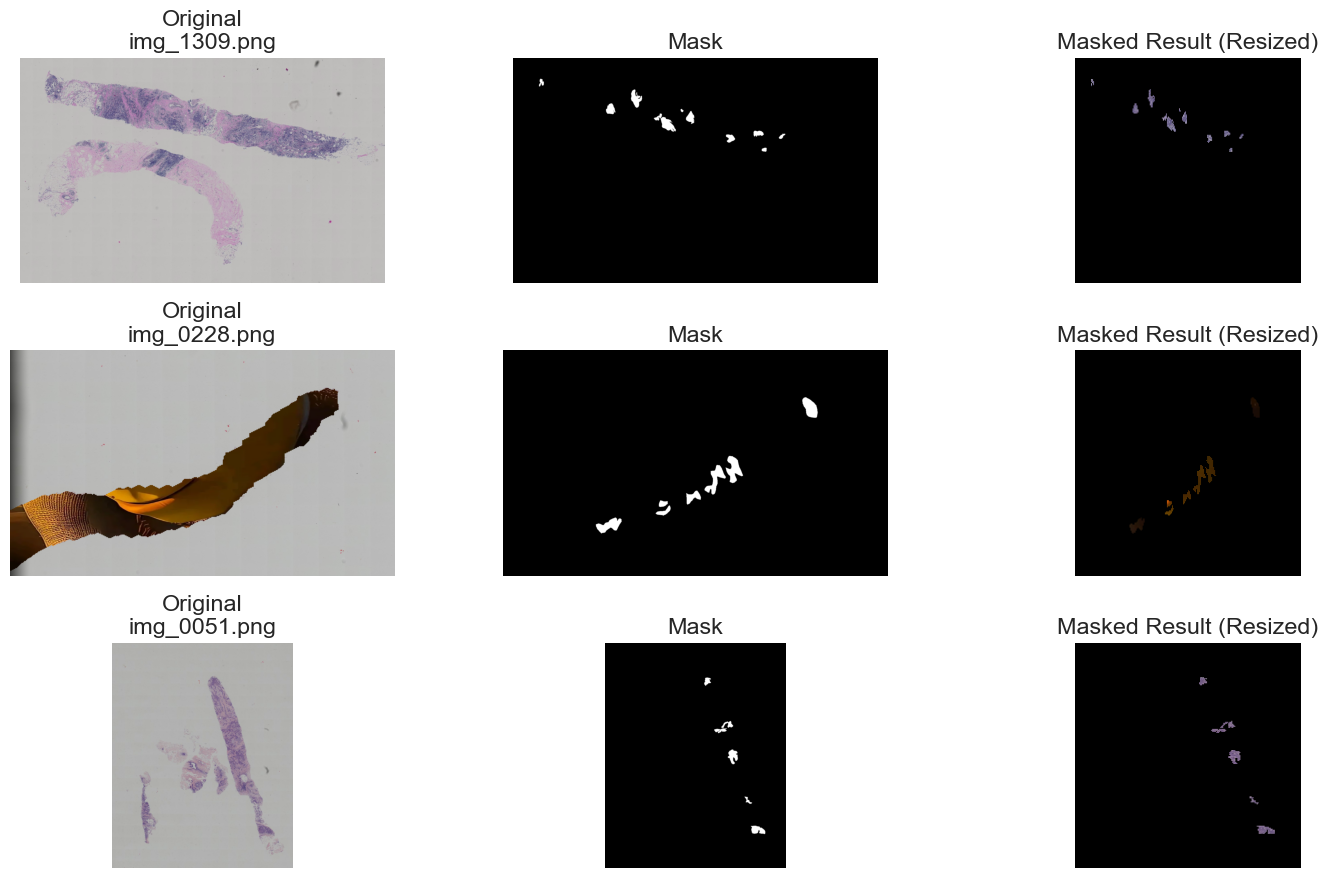

In [14]:
#@ title Mask Verification
# Select a few random images from the output folder to verify the process
masked_files = os.listdir(OUTPUT_FOLDER)
num_samples = 3
selected_files = random.sample(masked_files, num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

for i, filename in enumerate(selected_files):
    # 1. Define paths
    masked_image_path = os.path.join(OUTPUT_FOLDER, filename)
    original_image_path = os.path.join(SOURCE_FOLDER, filename)

    # Logic to find the mask path (replicating logic from Cell 5)
    mask_name = filename.replace('img_', 'mask_', 1)
    mask_path = os.path.join(SOURCE_FOLDER, mask_name)

    # Check if mask exists, if not try .png fallback as per Cell 5 logic
    if not os.path.exists(mask_path):
        mask_stem = os.path.splitext(filename)[0].replace('img_', 'mask_', 1)
        mask_path = os.path.join(SOURCE_FOLDER, mask_stem + ".png")

    # 2. Load images
    # Original
    orig_img = cv2.imread(original_image_path)
    if orig_img is not None:
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Masked (Result)
    masked_img = cv2.imread(masked_image_path)
    if masked_img is not None:
        masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)

    # 3. Plot
    # Original
    if orig_img is not None:
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Original\n{filename}")
    else:
        axes[i, 0].text(0.5, 0.5, "Original Not Found", ha='center')
    axes[i, 0].axis('off')

    # Mask
    if mask_img is not None:
        axes[i, 1].imshow(mask_img, cmap='gray')
        axes[i, 1].set_title(f"Mask")
    else:
        axes[i, 1].text(0.5, 0.5, "Mask Not Found", ha='center')
    axes[i, 1].axis('off')

    # Masked
    if masked_img is not None:
        axes[i, 2].imshow(masked_img)
        axes[i, 2].set_title(f"Masked Result (Resized)")
    else:
        axes[i, 2].text(0.5, 0.5, "Result Not Found", ha='center')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

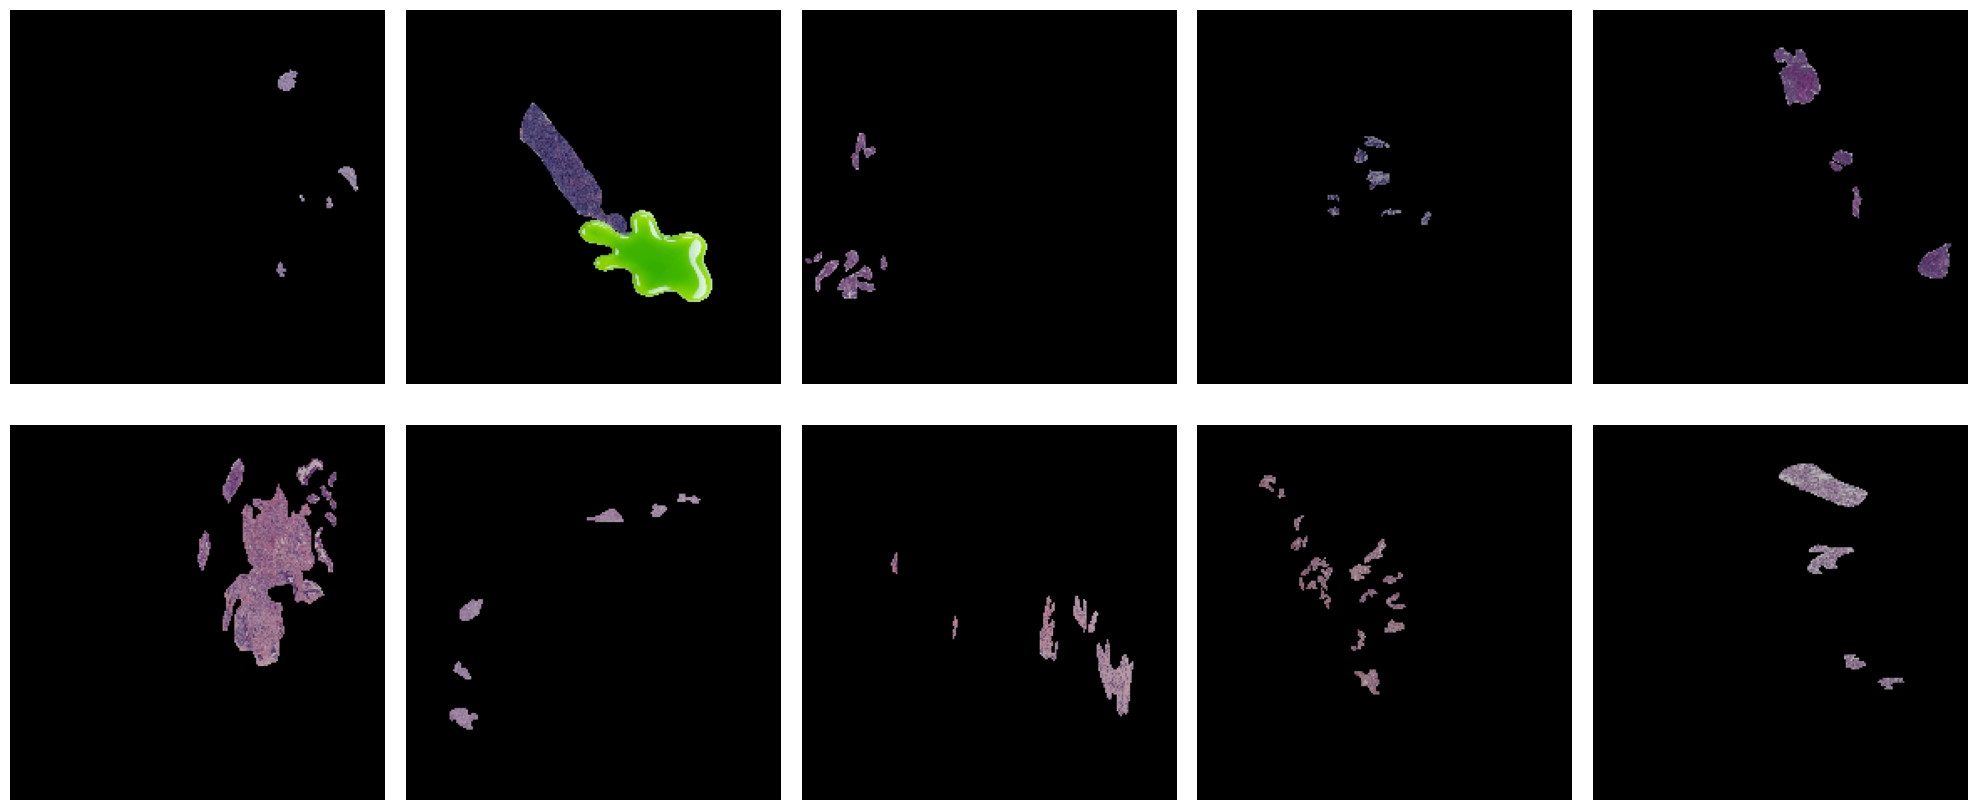

In [15]:
# Number of images to display
num_img = 10
# Starting index
start_img= random.randint(0, len(train_images) - num_img)
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



In [16]:
from sklearn.preprocessing import LabelEncoder

# 1. Load the labels CSV
labels_df = pd.read_csv(train_labels_path)
# Create a dictionary mapping filename -> label for fast lookup
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))

# 2. Get the filenames corresponding to the images loaded in Cell 7
# IMPORTANT: This must match the order used in 'load_images_from_folder' exactly.
# We use the filenames list created in the previous cell.
# filenames = os.listdir(MASKED_IMAGE_PATH)

print("Aligning labels to loaded images...")

X_aligned = []
y_aligned = []

# 3. Iterate through the filenames to sync X (images) and y (labels)
# We assume 'train_images' matches the order of 'filenames' because they rely on the same os.listdir call order
# provided no files were added/deleted between Cell 7 and Cell 9.
if len(filenames) != len(train_images):
    raise ValueError(f"Mismatch! Loaded images ({len(train_images)}) != Files found ({len(filenames)}).")

for i, filename in enumerate(filenames):
    if filename in labels_map:
        # If the file exists in our CSV, keep the image and the label
        X_aligned.append(train_images[i])
        y_aligned.append(labels_map[filename])
    else:
        # If image is in folder but NOT in CSV, we must discard the image
        print(f"Skipping {filename}: Image found but no label in CSV.")

# Convert to numpy arrays
X = np.array(X_aligned)
y = np.array(y_aligned)

print(f"Images aligned: {X.shape}")
print(f"Labels aligned: {y.shape}")

# 4. Encode labels (String -> Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class mapping
print("Classes:", label_encoder.classes_)

# 5. Train-Test Split (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=SEED,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

Aligning labels to loaded images...
Images aligned: (1412, 224, 224, 3)
Labels aligned: (1412,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Training data shape: (1129, 224, 224, 3), Labels: (1129,)
Validation data shape: (141, 224, 224, 3), Labels: (141,)
Test data shape: (142, 224, 224, 3), Labels: (142,)


In [17]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


In [18]:
from torch.utils.data import Dataset
from torchvision import transforms

# Define ImageNet constants (required for Phikon/ViT)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class HistopathologyDataset(Dataset):
    def __init__(self, images, labels, is_train=False):
        self.images = images
        self.labels = labels
        
        if is_train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(15),
                # Histology often benefits from slight color jitter
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Image is currently (224, 224, 3) numpy array
        img = self.images[idx]
        # Convert to uint8 for PIL if they are currently floats 0-1
        if img.dtype != np.uint8 and img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
            
        label = self.labels[idx]
        return self.transform(img), label

# Re-create datasets using this class instead of TensorDataset
# Note: Do not permute X_train before passing it here, the transform handles it
train_ds = HistopathologyDataset(X_train, y_train, is_train=True)
val_ds = HistopathologyDataset(X_val, y_val, is_train=False)
test_ds = HistopathologyDataset(X_test, y_test, is_train=False)

In [19]:
# Define the batch size
BATCH_SIZE = 32

In [20]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [21]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

## **4. Training Parameters**

In [ ]:
# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

NameError: name 'nn' is not defined

## **5. CNN Architecture**

## 5.1 Phikon

In [ ]:
import timm

# Load Phikon (ViT-Base) - 86M parameters
# This is much smaller than H-optimus-0 (1100M)
model_name = 'vit_base_patch16_224'

model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=0  # Remove head for feature extraction
)

# Standard preprocessing for this model
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

print(f"Loaded Phikon-Base. Parameters: {sum(p.numel() for p in model.parameters()):,}")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loaded Phikon-Base. Parameters: 85,798,656


In [ ]:
import torch.nn as nn


# 2. Freeze EVERYTHING
for param in model.parameters():
    param.requires_grad = False

# 3. Add a simple trainable classifier on top
# Phikon-Base outputs 768 features (ViT-Base standard)
class LightweightClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Linear(768, num_classes) # 768 -> 2 (Disease/Normal)

    def forward(self, x):
        features = self.backbone(x) # Shape: [Batch, 768]
        return self.head(features)

model_to_train = LightweightClassifier(model, num_classes=num_classes)

# Now only the 'head' parameters will update.
# You can train this on a standard laptop CPU if needed (though GPU is better).

## **7. Training**

### 7.1 Function Definitions

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_acc


def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_accuracy


def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=0, evaluation_metric="val_acc", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):
    """Train the neural network model."""

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Training', train_acc, epoch)
            writer.add_scalar('Accuracy/Validation', val_acc, epoch)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                    f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

### 7.2  Training Loop

In [ ]:
# Move model to device
model = model.to(device)

# Display model summary
#summary(model, input_size=input_shape)
model_graph = draw_graph(model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6, device=device)
summary(model_to_train, input_size=input_shape)
#model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
         Identity-11             [-1, 197, 768]               0
           Linear-12             [-1, 197, 768]         590,592
          Dropout-13             [-1, 197, 768]               0
        Attention-14             [-1, 1

In [ ]:
# 1. Move the trainable model to the device (GPU/CPU)
model_to_train = model_to_train.to(device)

# 2. Define Optimizer
# We only optimize parameters that require gradients (the head)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_to_train.parameters()),
    lr=LEARNING_RATE,
    weight_decay=L2_LAMBDA
)

# 3. Define Scaler for Mixed Precision Training
# Enabled only if CUDA is available to prevent errors on CPU
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# 4. Define TensorBoard Writer
writer = SummaryWriter(log_dir=f"{logs_dir}/phikon_finetune")

# 5. Run Training
model_to_train, tl_history = fit(
    model=model_to_train,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    patience=PATIENCE,
    evaluation_metric="val_acc",
    mode="max",)

final_val_acc = round(max(tl_history['val_acc']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc}%')


Training 1000 epochs...
Epoch   1/1000 | Train: Loss=0.7129, Acc=0.7263 | Val: Loss=1.8402, Acc=0.2766
Epoch   2/1000 | Train: Loss=0.6766, Acc=0.7520 | Val: Loss=1.8637, Acc=0.2908
Epoch   3/1000 | Train: Loss=0.6825, Acc=0.7414 | Val: Loss=1.8971, Acc=0.3404
Epoch   4/1000 | Train: Loss=0.6795, Acc=0.7405 | Val: Loss=1.8580, Acc=0.2979
Epoch   5/1000 | Train: Loss=0.6684, Acc=0.7582 | Val: Loss=1.8843, Acc=0.2908
Epoch   6/1000 | Train: Loss=0.6729, Acc=0.7458 | Val: Loss=1.8733, Acc=0.3121
Epoch   7/1000 | Train: Loss=0.6649, Acc=0.7679 | Val: Loss=1.8883, Acc=0.2908
Epoch   8/1000 | Train: Loss=0.6636, Acc=0.7653 | Val: Loss=1.9135, Acc=0.3050
Epoch   9/1000 | Train: Loss=0.6707, Acc=0.7422 | Val: Loss=1.9200, Acc=0.3404
Epoch  10/1000 | Train: Loss=0.6609, Acc=0.7564 | Val: Loss=1.9076, Acc=0.2908
Epoch  11/1000 | Train: Loss=0.6678, Acc=0.7493 | Val: Loss=1.9131, Acc=0.2979
Epoch  12/1000 | Train: Loss=0.6479, Acc=0.7626 | Val: Loss=1.9452, Acc=0.3050
Epoch  13/1000 | Train: Loss

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(tl_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(tl_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#ff7f0e')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()